# BOUNDARY ABLATION

This notebook demonstrates that ablating the boundary regions results in faster performance/loss drop-off than ablating random regions.

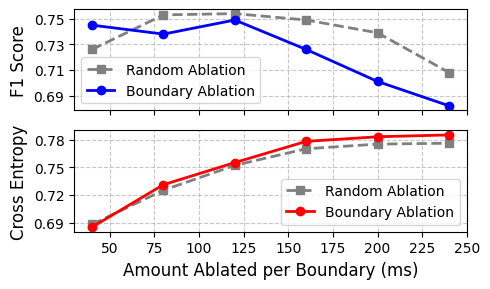

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('boundary_ablation.csv')

# Set up the figure and axes for two side-by-side plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3))

# Plot 1: F1 Score comparison
ax1.plot(df['Amount ablated'] * 1000, df['Rand F1'], marker='s', label='Random Ablation', color='gray', linestyle='--', linewidth=2)
ax1.plot(df['Amount ablated'] * 1000, df['F1 score'], marker='o', label='Boundary Ablation', color='blue', linewidth=2)
#ax1.set_xlabel('Amount Ablated', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
#ax1.set_title('Boundary Ablation Impact on F1 Score and Loss', fontsize=16)
ax1.legend()
ax1.xaxis.set_ticklabels([])
#ax1.xaxis.set_ticks([50, 100, 150, 200, 250])
ax1.yaxis.set_ticks([0.69, 0.71, 0.73, 0.75])
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Loss comparison
ax2.plot(df['Amount ablated'] * 1000, df['Rand Loss'], marker='s', label='Random Ablation', color='gray', linestyle='--', linewidth=2)
ax2.plot(df['Amount ablated'] * 1000, df['Loss'], marker='o', label='Boundary Ablation', color='red', linewidth=2)
ax2.set_xlabel('Amount Ablated per Boundary (ms)', fontsize=12)
ax2.set_ylabel('Cross Entropy', fontsize=12)
#ax2.set_title('Impact on Loss', fontsize=14)
ax2.legend(loc="lower right")
#ax2.xaxis.set_ticks([50, 100, 150, 200, 250])
ax2.yaxis.set_ticks([0.69, 0.72, 0.75, 0.78])
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.savefig("boundary-ablation-impact.pdf")
# Display the plots
plt.show()

Also, the example attention trace:

In [2]:
%cd "../recipes/QPN/interpret/"

/home/competerscience/Documents/Repositories/ParkinsonSpeechAI/recipes/QPN/interpret


In [12]:
import hyperpyyaml

DEVICE = "cuda"

overrides = {
    "data_folder": "/path/to/qpn",
    "storage_folder": "results",
    "pretrained_source": "openai/whisper-small",
}
with open("results/whisper_small_all_sae/seed_2050/hyperparams.yaml") as f:
    hparams = hyperpyyaml.load_hyperpyyaml(f, overrides=overrides)
hparams["pretrainer"].collect_files()
hparams["pretrainer"].load_collected()
compute_features = hparams["compute_features"].to(DEVICE).eval()
embedding_model = hparams["embedding_model"].to(DEVICE).eval()
classifier = hparams["classifier"].to(DEVICE).eval()
hparams["embedding_sae"].insert_adapters()
embedding_sae = hparams["embedding_sae"].to(DEVICE).eval()
sae_layer = embedding_sae.get_submodule(hparams["sae_layer"])
sae_layer.enable_storage()


hparams["checkpointer"].recover_if_possible()


# Forward pass
def attention_trace(audio):
    """Load model and trace attention"""
    features = compute_features(audio)
    embedding = embedding_sae(features)

    attention_scores = sae_layer.attention_scores.detach().clone()
    norm_attention = attention_scores / attention_scores.max()

    return norm_attention

speechbrain.integrations.huggingface.huggingface - WhisperModel is frozen.
speechbrain.integrations.huggingface.whisper - whisper encoder-decoder is frozen.


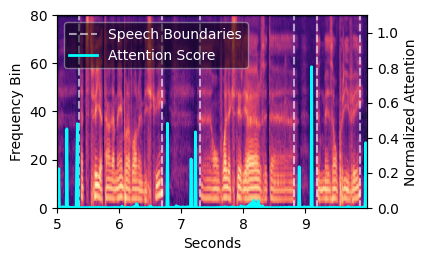

In [17]:
import numpy as np
import speechbrain
import json
import sys

sys.path.append("../../../biomarker_analysis")
from generate_scores_human_samples_qpn import extract_segments

with open("results/test.json") as f:
    test_data = json.load(f)

def audio_pipeline(wav, duration, start):
    sig, fs = speechbrain.dataio.audio_io.load(
        wav,
        num_frames=int(duration * 16000),
        frame_offset=int(start * 16000),
    )

    return sig.squeeze(0)


# 1. Setup figure - using a single subplot or keeping two if you want to compare

# Indices and time calculation
indexes = np.arange(500) + 500
xs = indexes / 100
t_start, t_end = xs[0], xs[-1]

# Get spectral features
sample_id = "qpn_MNI0249_dpt_fr_Batch2_0"
sample = test_data[sample_id]

fig, ax1 = plt.subplots(1, 1, figsize=(4, 2.5))


audio = audio_pipeline(sample["wav"], sample["duration"], sample["start"]).to(DEVICE)
energy = audio.square().unfold(dimension=0, size=640, step=320).sum(dim=-1).squeeze()
boundaries = extract_segments(energy, 0.01, invert=False).diff().cpu().detach()
spec = speechbrain.lobes.features.Fbank(n_fft=640, n_mels=80, win_length=40, hop_length=20)(audio.unsqueeze(0)).cpu().detach().squeeze().T

    
# 2. Plot Spectrogram with 'extent' to match the time (xs)
# spec.shape[0] is the number of frequency bins
num_bins = spec.shape[0]
ax1.imshow(spec[:, indexes], aspect="auto", origin="lower", 
           extent=[t_start, t_end, 0, num_bins], cmap='magma')

# 3. Overlay Speech Boundaries
# We iterate through the nonzero indices of the boundary mask
#boundaries = frame_score_from_energy(energies[sample_id])[indexes].nonzero()[0]
for i, idx in enumerate(boundaries[indexes].nonzero()):
    # Convert local index back to seconds
    boundary_time = (idx + 500) / 100
    ax1.axvline(x=boundary_time, linestyle="--", color="white", alpha=0.6,
                label="Speech Boundaries" if i == 0 else None)

# 4. Overlay Attention Score
# We create a twin axis so the attention score (0-1) doesn't interfere 
# with the frequency bin y-axis (0-80+)
ax1_twin = ax1.twinx()
norm_attention = attention_trace(audio.unsqueeze(0)).cpu().detach()
norm_attention = norm_attention[0, indexes]

ax1_twin.plot(xs, norm_attention, color="cyan", lw=2, label="Attention Score")
ax1_twin.set_ylabel("Normalized Attention")
ax1_twin.set_ylim(0, 1.1) # Extra headroom
ax1_twin.tick_params(axis='y')

# Final formatting
ax1.set_xlabel("Seconds")
ax1.set_ylabel("Frequency Bin")
#ax1.set_title("Attention and Boundaries overlaid on Spectrogram")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", framealpha=0.5, facecolor="black", labelcolor="white")

fig.savefig("attention_on_spectrogram.pdf", bbox_inches="tight")
